In [18]:
import torch
from ultralytics.nn.modules.block import C3k2, SPPF, C2PSA
from ultralytics.nn.modules.conv import Conv
from ultralytics.nn.modules.head import Detect
from torchinfo import summary

def print_structure(model, indent='', depth=0):
        if depth > 3:
            return
        for name, child in model.named_children():
            print(f"{indent}└─ {name}: {child.__class__.__name__}")
            print_structure(child, indent + '  ', depth + 1)

def print_model_info(model, input_size, name):
    print(f"\n=== {name} 모델 정보 ===")
    if isinstance(input_size, tuple):
        summary(model, 
                input_size=input_size,
                verbose=0,
                depth=3,  # depth를 3으로 수정
                col_names=["output_size", "num_params"])
    
    # 3단계 깊이까지 구조 출력
    def print_structure(model, indent='', depth=0):
        if depth > 3:
            return
        for name, child in model.named_children():
            print(f"{indent}└─ {name}: {child.__class__.__name__}")
            print_structure(child, indent + '  ', depth + 1)
    
    print("\n상세 구조:")
    print_structure(model)

# 모델들 출력
model_c3k2 = C3k2(c1=64, c2=128, n=3, c3k=True)
print_model_info(model_c3k2, (1, 64, 128, 128), "C3k2")

model_conv = Conv(c1=30, c2=64, k=3, s=1)
print_model_info(model_conv, (1, 30, 224, 224), "Conv")

model_sppf = SPPF(c1=512, c2=1024, k=5)
print_model_info(model_sppf, (1, 512, 32, 32), "SPPF")

model_c2psa = C2PSA(c1=256, c2=256, n=3, e=0.5)
print_model_info(model_c2psa, (1, 256, 64, 64), "C2PSA")

# Detect 모델은 summary 없이 구조만 출력
print("\n=== Detect 모델 정보 ===")
model_detect = Detect(nc=10, ch=[256, 256, 256])
print("\n상세 구조:")
print_structure(model_detect)


=== C3k2 모델 정보 ===

상세 구조:
└─ cv1: Conv
  └─ conv: Conv2d
  └─ bn: BatchNorm2d
  └─ act: SiLU
└─ cv2: Conv
  └─ conv: Conv2d
  └─ bn: BatchNorm2d
  └─ act: SiLU
└─ m: ModuleList
  └─ 0: C3k
    └─ cv1: Conv
      └─ conv: Conv2d
      └─ bn: BatchNorm2d
      └─ act: SiLU
    └─ cv2: Conv
      └─ conv: Conv2d
      └─ bn: BatchNorm2d
      └─ act: SiLU
    └─ cv3: Conv
      └─ conv: Conv2d
      └─ bn: BatchNorm2d
      └─ act: SiLU
    └─ m: Sequential
      └─ 0: Bottleneck
      └─ 1: Bottleneck
  └─ 1: C3k
    └─ cv1: Conv
      └─ conv: Conv2d
      └─ bn: BatchNorm2d
      └─ act: SiLU
    └─ cv2: Conv
      └─ conv: Conv2d
      └─ bn: BatchNorm2d
      └─ act: SiLU
    └─ cv3: Conv
      └─ conv: Conv2d
      └─ bn: BatchNorm2d
      └─ act: SiLU
    └─ m: Sequential
      └─ 0: Bottleneck
      └─ 1: Bottleneck
  └─ 2: C3k
    └─ cv1: Conv
      └─ conv: Conv2d
      └─ bn: BatchNorm2d
      └─ act: SiLU
    └─ cv2: Conv
      └─ conv: Conv2d
      └─ bn: BatchNorm2d
      

In [2]:
from ultralytics import YOLO

import torch
from ultralytics.nn.modules.block import C3k2

# 입력 텐서 생성 (배치 크기: 1, 채널 수: 64, 높이: 128, 너비: 128)
x = torch.randn(1, 64, 128, 128)

# C3k2 클래스 인스턴스 생성
# 입력 채널 수: 64, 출력 채널 수: 128, 블록 수: 3, c3k 사용 여부: True
model = C3k2(c1=64, c2=128, n=3, c3k=True)

# 모델에 입력 텐서 전달
output = model(x)

# 출력 텐서의 크기 출력
print(output.shape)

torch.Size([1, 128, 128, 128])


In [4]:
import torch
from ultralytics.nn.modules.conv import Conv

# 입력 텐서 생성 (배치 크기: 1, 채널 수: 3, 높이: 224, 너비: 224)
x = torch.randn(1, 30, 224, 224)

# Conv 클래스 인스턴스 생성
# 입력 채널 수: 3, 출력 채널 수: 64, 커널 크기: 3, 스트라이드: 1, 패딩: 자동
conv_layer = Conv(c1=30, c2=64, k=3, s=1)

# Conv 레이어에 입력 텐서 전달
output = conv_layer(x)

# 출력 텐서의 크기 출력
print(output.shape)

torch.Size([1, 64, 224, 224])


In [ ]:
import torch
from ultralytics.nn.modules.block import SPPF

'''
SPPF(Spatial Pyramid Pooling - Fast) 모듈은 YOLOv5에서 사용되는 레이어로, 입력 특징 맵에 대해 공간 피라미드 풀링을 수행하여 다양한 크기의 맥스 풀링 결과를 결합합니다. 이를 통해 다양한 스케일의 정보를 효과적으로 통합할 수 있습니다. SPPF 모듈은 특히 빠른 연산을 위해 최적화되어 있습니다.

주요 역할:

다양한 스케일의 정보 통합: 서로 다른 크기의 맥스 풀링을 통해 다양한 스케일의 정보를 추출하고 이를 결합합니다.
특징 맵의 크기 유지: 입력 특징 맵의 공간적 크기를 유지하면서 채널 수를 증가시킵니다.
연산 효율성: 빠른 연산을 위해 최적화된 구조를 사용합니다.
SPPF 모듈의 구조는 다음과 같습니다:

입력 채널 수를 절반으로 줄이는 1x1 컨볼루션 레이어
5x5 맥스 풀링 레이어를 세 번 반복하여 다양한 스케일의 정보를 추출
추출된 정보를 결합한 후 출력 채널 수를 원하는 값으로 조정하는 1x1 컨볼루션 레이어
이를 통해 입력 특징 맵의 공간적 크기를 유지하면서 다양한 스케일의 정보를 효과적으로 통합할 수 있습니다.
'''
# 입력 텐서 생성 (배치 크기: 1, 채널 수: 512, 높이: 32, 너비: 32)
x = torch.randn(1, 512, 32, 32)

# SPPF 클래스 인스턴스 생성
# 입력 채널 수: 512, 출력 채널 수: 1024, 커널 크기: 5
sppf_layer = SPPF(c1=512, c2=1024, k=5)

# SPPF 레이어에 입력 텐서 전달
output = sppf_layer(x)

# 출력 텐서의 크기 출력
print(output.shape)

torch.Size([1, 1024, 32, 32])


In [5]:
import torch
from ultralytics.nn.modules.block import C2PSA

# 입력 텐서 생성 (배치 크기: 1, 채널 수: 256, 높이: 64, 너비: 64)
x = torch.randn(1, 256, 64, 64)

# C2PSA 클래스 인스턴스 생성
# 입력 채널 수: 256, 출력 채널 수: 256, 블록 수: 3, 확장 비율: 0.5
model = C2PSA(c1=256, c2=256, n=3, e=0.5)

# 모델에 입력 텐서 전달
output = model(x)

# 출력 텐서의 크기 출력
print(output.shape)

torch.Size([1, 256, 64, 64])


In [32]:
import torch
from ultralytics.nn.modules.head import Detect

# 3개의 서로 다른 크기의 특징맵 생성 
# (batch_size, channels, height, width)
feature_maps = [
    torch.randn(1, 256, 80, 80),    # P3
    torch.randn(1, 256, 40, 40),    # P4  
    torch.randn(1, 256, 20, 20)     # P5
]

# Detect 레이어 초기화
# nc: 클래스 수 80개 (COCO dataset)
# anchors: 3개의 스케일(P3,P4,P5)에 각각 3개의 앵커
# ch: 입력 특징맵의 채널 수 
detect = Detect(nc=10, ch=[256, 256, 256])

# 추론 모드로 설정
detect.eval()

# 추론 실행
with torch.no_grad():
    predictions = detect(feature_maps)

# 출력 형태 확인 
# (batch_size, num_anchors_total, num_classes + 5)
print(predictions[0].shape)


torch.Size([1, 14, 8400])


In [31]:
temp = predictions[1]
print(temp[0].shape)
print(temp[1].shape)
print(temp[2].shape)


torch.Size([1, 144, 80, 80])
torch.Size([1, 144, 40, 40])
torch.Size([1, 144, 20, 20])


In [27]:
import torch
from torch import nn
from ultralytics.nn.modules.conv import Conv, DWConv


class Detect3D(nn.Module):
    """YOLO Detect head for 3D coordinate detection."""
    
    dynamic = False
    export = False
    end2end = False
    max_det = 300
    shape = None
    anchors = torch.empty(0)
    strides = torch.empty(0)
    
    def __init__(self, nc=80, ch=()):
        super().__init__()
        self.nc = nc  # 클래스 수
        self.nl = len(ch)  # detection layer 수
        self.reg_max = 16  # DFL channels
        self.no = nc + self.reg_max * 3  # 출력 수 (클래스 + xyz 좌표)
        self.stride = torch.zeros(self.nl)
        
        # 채널 수 계산
        c2 = max((16, ch[0] // 4, self.reg_max * 3))  # xyz를 위한 채널
        c3 = max(ch[0], min(self.nc, 100))  # 클래스를 위한 채널
        
        # xyz 좌표 예측을 위한 컨볼루션
        self.cv2 = nn.ModuleList(
            nn.Sequential(
                Conv(x, c2, 3),
                Conv(c2, c2, 3),
                nn.Conv2d(c2, 3 * self.reg_max, 1)  # xyz 좌표를 위한 출력
            ) for x in ch
        )
        
        # 클래스 예측을 위한 컨볼루션
        self.cv3 = nn.ModuleList(
            nn.Sequential(
                DWConv(x, x, 3),
                Conv(x, c3, 1),
                nn.Conv2d(c3, self.nc, 1)
            ) for x in ch
        )

    def forward(self, x):
        if self.training:
            return self._forward_train(x)
        return self._forward_inference(x)

    def _forward_train(self, x):
        coord_preds = []  # xyz 좌표 예측
        cls_preds = []    # 클래스 예측
        
        for i in range(self.nl):
            coords = self.cv2[i](x[i])  # xyz 좌표
            cls = self.cv3[i](x[i])     # 클래스
            coord_preds.append(coords)
            cls_preds.append(cls)
            
        return coord_preds, cls_preds

    def _forward_inference(self, x):
        z = []  # inference output
        
        for i in range(self.nl):
            coords = self.cv2[i](x[i])  # xyz 좌표
            cls = self.cv3[i](x[i])     # 클래스
            
            # coords와 cls를 결합
            y = torch.cat((coords, cls), 1)
            
            # 크기를 P3 크기로 조정 (80x80)
            if i > 0:  # P4, P5는 업샘플링
                y = nn.functional.interpolate(
                    y, 
                    size=(80, 80),  # P3 크기로 맞춤
                    mode='bilinear', 
                    align_corners=False
                )
            z.append(y)
        
        return torch.cat(z, 1), x

In [28]:
import torch
from torch import nn

# 3개의 서로 다른 크기의 특징맵 생성 
# (batch_size, channels, height, width)
feature_maps = [
    torch.randn(1, 256, 80, 80),    # P3
    torch.randn(1, 256, 40, 40),    # P4  
    torch.randn(1, 256, 20, 20)     # P5
]

# Detect3D 레이어 초기화
detect3d = Detect3D(nc=10, ch=[256, 256, 256])

# 학습 모드 출력 확인
detect3d.train()
training_output = detect3d(feature_maps)
coord_preds, cls_preds = training_output

print("=== 학습 모드 출력 ===")
print("좌표 예측:")
for i, coord in enumerate(coord_preds):
    print(f"P{i+3} 좌표 shape:", coord.shape)
print("\n클래스 예측:")
for i, cls in enumerate(cls_preds):
    print(f"P{i+3} 클래스 shape:", cls.shape)

# 추론 모드 출력 확인
detect3d.eval()
with torch.no_grad():
    inference_output = detect3d(feature_maps)
    predictions, feature_maps = inference_output

print("\n=== 추론 모드 출력 ===")
print("예측 텐서 shape:", predictions.shape)

=== 학습 모드 출력 ===
좌표 예측:
P3 좌표 shape: torch.Size([1, 48, 80, 80])
P4 좌표 shape: torch.Size([1, 48, 40, 40])
P5 좌표 shape: torch.Size([1, 48, 20, 20])

클래스 예측:
P3 클래스 shape: torch.Size([1, 10, 80, 80])
P4 클래스 shape: torch.Size([1, 10, 40, 40])
P5 클래스 shape: torch.Size([1, 10, 20, 20])

=== 추론 모드 출력 ===
예측 텐서 shape: torch.Size([1, 174, 80, 80])



=== YOLOv11 Backbone 모델 정보 ===

상세 구조:
└─ 0: Conv
  └─ conv: Conv2d
  └─ bn: BatchNorm2d
  └─ act: SiLU
└─ 1: Conv
  └─ conv: Conv2d
  └─ bn: BatchNorm2d
  └─ act: SiLU
└─ 2: C3k2
  └─ cv1: Conv
    └─ conv: Conv2d
    └─ bn: BatchNorm2d
    └─ act: SiLU
  └─ cv2: Conv
    └─ conv: Conv2d
    └─ bn: BatchNorm2d
    └─ act: SiLU
  └─ m: ModuleList
    └─ 0: Bottleneck
      └─ cv1: Conv
      └─ cv2: Conv
└─ 3: Conv
  └─ conv: Conv2d
  └─ bn: BatchNorm2d
  └─ act: SiLU
└─ 4: C3k2
  └─ cv1: Conv
    └─ conv: Conv2d
    └─ bn: BatchNorm2d
    └─ act: SiLU
  └─ cv2: Conv
    └─ conv: Conv2d
    └─ bn: BatchNorm2d
    └─ act: SiLU
  └─ m: ModuleList
    └─ 0: Bottleneck
      └─ cv1: Conv
      └─ cv2: Conv
└─ 5: Conv
  └─ conv: Conv2d
  └─ bn: BatchNorm2d
  └─ act: SiLU
└─ 6: C3k2
  └─ cv1: Conv
    └─ conv: Conv2d
    └─ bn: BatchNorm2d
    └─ act: SiLU
  └─ cv2: Conv
    └─ conv: Conv2d
    └─ bn: BatchNorm2d
    └─ act: SiLU
  └─ m: ModuleList
    └─ 0: C3k
      └─ cv1: Conv
      └─ 

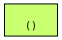

In [ ]:
# 필요한 라이브러리 임포트
import torch
from ultralytics import YOLO
from torchviz import make_dot

# 모델 로드
model = YOLO('yolo11n.pt')


backbone_layers = list(model.model.model.children())[:10]
model = nn.Sequential(*backbone_layers)
# 임의의 입력 데이터 생성
x = torch.randn(1, 3, 640, 640)

# 모델 그래프 시각화
model.eval()  # 평가 모드로 전환

# hooks를 사용하여 모델의 내부 연산을 캡처
def forward_hook(module, input, output):
    pass  # 후에 필요하면 사용

# 모든 모듈에 hook 등록 (필요 시)
for module in model.modules():
    module.register_forward_hook(forward_hook)

# 전체 연산 그래프를 추적하기 위해 출력값을 하나의 스칼라로 변환
# 이때, 출력값의 합(sum)을 사용하여 하나의 텐서로 만듭니다.
with torch.no_grad():
    y = model(x)
    if isinstance(y, (list, tuple)):
        y = [output if isinstance(output, torch.Tensor) else torch.tensor(0.) for output in y]
        y = sum([output.sum() for output in y])
    elif isinstance(y, torch.Tensor):
        y = y.sum()
    else:
        y = torch.tensor(0.)

def print_structure(model, indent='', depth=0):
        if depth > 3:
            return
        for name, child in model.named_children():
            print(f"{indent}└─ {name}: {child.__class__.__name__}")
            print_structure(child, indent + '  ', depth + 1)

def print_model_info(model, input_size, name):
    print(f"\n=== {name} 모델 정보 ===")
    if isinstance(input_size, tuple):
        summary(model, 
                input_size=input_size,
                verbose=0,
                depth=3,  # depth를 3으로 수정
                col_names=["output_size", "num_params"])
    
    # 3단계 깊이까지 구조 출력
    def print_structure(model, indent='', depth=0):
        if depth > 3:
            return
        for name, child in model.named_children():
            print(f"{indent}└─ {name}: {child.__class__.__name__}")
            print_structure(child, indent + '  ', depth + 1)
    
    print("\n상세 구조:")
    print_structure(model)
    
# 모델 정보 출력
print_model_info(model, (1, 3, 640, 640), "YOLOv11 Backbone")
print("=== 모델 그래프 시각화 ===")
print()